# Parameter estimation using qualitative data

This Notebook eplains the use of qualitative data for parameter estimation, as described in [Schmiester et al. (2020)](https://link.springer.com/article/10.1007/s00285-020-01522-w) and [Schmiester et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.02.06.430039v1.abstract).

## Specification of qualitative data in the PEtab format

The qualitative data can be specified as a non-standard extension to [PEtab](https://journals.plos.org/ploscompbiol/article?rev=2&id=10.1371/journal.pcbi.1008646). Categories can be defined as observable Parameters. Datapoints can be collected into categories by assigning the same `observableParameters` in the measurement file. In the following example, we have measurements at the first two timepoints belonging to category 1 and a measurement at a third timepoint belonging to category 2:

| observableId | simulationConditionId | measurement | time | observableParameters |
|--------------|-----------------------|-------------|------|----------------------|
| observable_1 | condition_1           |          1   | 1    | category_1           |
| observable_1 | condition_1           |          1   | 2    | category_1           |
| observable_1 | condition_1           |          2   | 3    | category_2           |

pyPESTO recognizes these parameters as optimal scaling categories via the `parameterType`, `parameterGroup` and `parameterCategory` columns in the parameters file. The parameters file then looks like (we only show the columns important for qualitative data here):

| parameterId | estimate | hierarchicalOptimization | parameterType       | parameterGroup | parameterCategory |
|-------------|----------|--------------------------|---------------------|----------------|-------------------|
| parameter_1 | 1        | 0                        |                     |                |                   |
| category_1  | 1        | 1                        | qualitative_scaling | 1              | 1                 |
| category_2  | 1        | 1                        | qualitative_scaling | 1              | 2                 |

`parameterType=qualitative_scaling` identifies the parameter as an optimal scaling parameter. The `parameterGroup` is an integer, specifying if these parameters are comparable or from different qualitative datasets, where no qualitative relation is known between them (e.g. different observables). `parameterCategory` is also an integer, which defines the category index in ascending order, i.e. `category 1 < category 2 < ...`. Both are indexed starting with 1. An example how this looks like in detail is provided in the `example_qualitative` folder. Additional examples are provided as supplementary material to [Schmiester et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.02.06.430039v1.abstract).

## Import model and create pyPESTO objective

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize

import amici
import petab
import numpy as np
from pypesto.hierarchical.optimal_scaling_solver import OptimalScalingInnerSolver
import pypesto.logging
import logging

In [2]:
petab_folder = './example_qualitative/'
yaml_file = 'example_qualitative.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

In [3]:
# To enable the optimal scaling approach for qualitative data, set qualitative=True, when creating the objective

objective = importer.create_objective(qualitative=True)
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

## Evaluation of the objective function

After creating the pyPESTO optimal scaling objective function, it can be called with a parameter vector as input. It will output either the objective function value or additionally the gradient, if it is required.

In [4]:
# Evaluation of the objective function without gradients
print(f'Objective function value: {objective(petab_problem.x_nominal_scaled)}')

# The sensi_orders input can be used to specify, that also gradients need to be computed
print(f'Objective function and gradient: {objective(petab_problem.x_nominal_scaled, sensi_orders=(0,1))}')

Objective function value: 0.010643646572165256
Objective function and gradient: (0.010643646546700499, array([ 0.        ,  0.        ,  0.02205115, -0.0266729 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]))


## Run optimization using the optimal scaling approach

We test parameter estimation using the Scipy optimizer Powell (gradient-free) and L-BFGS-B (gradient-based). In this example we use multi-start optimization with 10 starts.

In [5]:
# create a pyPESTO optimizer using the gradient-free Powell algorithm
optimizer_gf = optimize.ScipyOptimizer(method='powell',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

# create a pyPESTO optimizer using the gradient-based L-BFGS-B algorithm
optimizer_gb = optimize.ScipyOptimizer(method='L-BFGS-B',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

n_starts = 10

The optimal scaling problem can be solved in different ways, which can be chosen in the pyPESTO problem. The different approaches are described in detail in [Schmiester et al. (2020)](https://link.springer.com/article/10.1007/s00285-020-01522-w). The options are:
- method:  `standard` / `reduced` (default)
- reparameterized: `True` (default) / `False`
- intervalConstraints: `max` (default) / `max-min`
- minGap: Any float value (default: 1e-10)

It is recommended to use the reduced method with reparameterization and `max` interval constraints as it is the most efficient and robust choice ([Schmiester et al. (2020)](https://link.springer.com/article/10.1007/s00285-020-01522-w)), which we will also use here.

### Run optimization with the gradient-free optimizer

In [6]:
# Set the options for solving the optimal scaling problem
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': True,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})
# Run optimization with the gradient-free optimizer
history_options = pypesto.HistoryOptions(trace_record=True)

res_gf = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gf, engine=engine, history_options=history_options)

Function values from history and optimizer do not match: 0.0005704175003913785, 0.0005735454850299722
Parameters obtained from history and optimizer do not match: [6.99038852 5.11924138], [4.99999336 3.1460019 ]


Function values from history and optimizer do not match: 0.0005700825012818066, 0.0005735454463044645
Parameters obtained from history and optimizer do not match: [6.87204882 5.02451076], [4.99999589 3.14606276]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 6
         Function evaluations: 481


Function values from history and optimizer do not match: 0.0005700601359206306, 0.0005735454651078631
Parameters obtained from history and optimizer do not match: [6.67056965 4.82057758], [4.99999699 3.14615276]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 5
         Function evaluations: 371


Function values from history and optimizer do not match: 0.0005799298278070047, 0.0005894352324732224
Parameters obtained from history and optimizer do not match: [5.68888335 3.74608907], [5.         3.02892112]


Function values from history and optimizer do not match: 0.000573247359443544, 0.0005735514022347194
Parameters obtained from history and optimizer do not match: [6.93735232 5.03226437], [4.99999721 3.14386471]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 6
         Function evaluations: 326


### Run optimization with the gradient-based optimizer

Gradients are computed using the semi-analytical algorithm presented in [Schmiester et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.02.06.430039v1.abstract).

In [7]:
res_gb = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gb, engine=engine, history_options=history_options)

### Compare results

Gradient-based optimization leads to improved computation times

In [8]:
time_gf = res_gf.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-free optimizer: {np.mean(time_gf)}")

time_gb = res_gb.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based optimizer: {np.mean(time_gb)}")


Mean computation time for gradient-free optimizer: 9.340456819534301
Mean computation time for gradient-based optimizer: 4.557369327545166


Both optimizers yield the same final objective function values

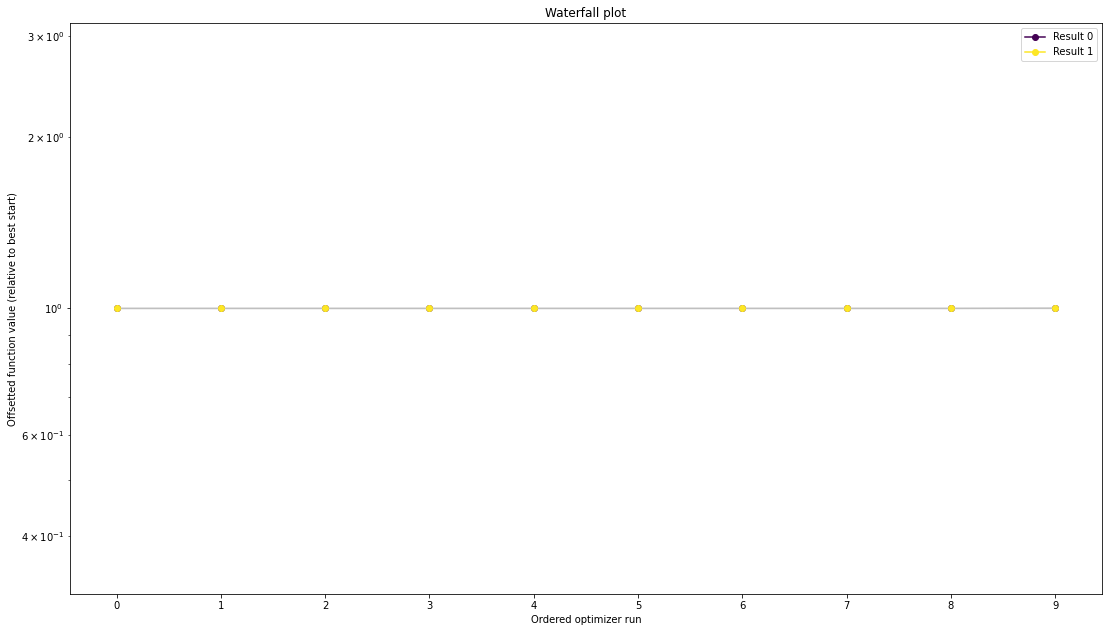

In [9]:
from pypesto.visualize import waterfall

waterfall([res_gf, res_gb])